In [65]:
import pandas as pd 
import wandb
import numpy as np
api = wandb.Api()

In [66]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()
sns.set_context("notebook", font_scale=1.2)

In [67]:
metrics = ['test/result_acc/eval/'+ x for x in ['I', 'SS', 'LS', 'SL', 'LL']] + ['test/result_acc/avg']

In [68]:
def filter_run(summary):
    return True

runs = api.runs("qli/HINT_scaling_law")
summary_list = [] 
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary = {'name': run.name}
    summary.update(run.summary._json_dict)
    summary.update(run.config)
    if filter_run(summary):
        summary_list.append(summary)
df = {k: [x.get(k, '') for x in summary_list] for k in summary_list[0]}
df = pd.DataFrame(df)
print('number of runs:', len(summary_list))

number of runs: 50


Target accuracy: 90, M: 10^33


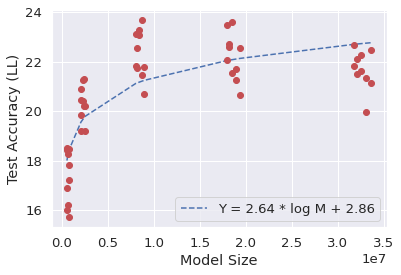

In [69]:
from scipy.optimize import curve_fit

def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c

def func_loglinear(x, a, b):
    return a * np.log10(x) + b

target_func = func_loglinear

X = df['n_params']
y = df[metrics[4]] * 100

data = list(zip(X, y))
data.sort()
X = [d[0] for d in data]
y = [d[1] for d in data]

popt, pcov = curve_fit(target_func, X, y)
a, b = popt
equation = f'Y = {a:.2f} * log M + {b:.2f}'
target_acc = 90
logN = (target_acc - b) / a 
print(f'Target accuracy: {target_acc}, M: 10^{logN:.0f}')

plt.plot(X, target_func(X, *popt), '--', label=equation)
plt.plot(X, y, 'ro')
plt.xlabel('Model Size')
plt.ylabel('Test Accuracy (LL)')
plt.legend(loc='lower right')
plt.savefig('figures/scaling_law_model.pdf', dpi=300, bbox_inches='tight')
plt.show()

scaling_model = (X, y, popt, equation)

In [70]:
def filter_run(summary):
    return summary.get('train_size') is not None

runs = api.runs("qli/HINT")
summary_list = [] 
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary = {'name': run.name}
    summary.update(run.summary._json_dict)
    summary.update(run.config)
    if filter_run(summary):
        summary_list.append(summary)
df = {k: [x.get(k, '') for x in summary_list] for k in summary_list[0]}
df = pd.DataFrame(df)
print('number of runs:', len(summary_list))

number of runs: 12


Target accuracy: 90, D: 10^15


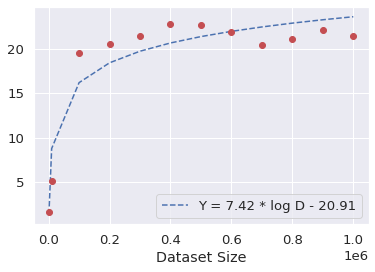

In [71]:
def func_loglinear(x, a, b):
    return a * np.log10(x) + b

target_func = func_loglinear

X = df['train_size'] * 1e6
y = df[metrics[4]] * 100

data = list(zip(X, y))
data.sort()
X = [d[0] for d in data]
y = [d[1] for d in data]

popt, pcov = curve_fit(target_func, X, y)
a, b = popt
equation = f'Y = {a:.2f} * log D ' + ('-' if b < 0 else '+') + f' {abs(b):.2f}'
target_acc = 90
logN = (target_acc - b) / a 
print(f'Target accuracy: {target_acc}, D: 10^{logN:.0f}')

plt.plot(X, target_func(X, *popt), '--', label=equation)
plt.plot(X, y, 'ro')
plt.xlabel('Dataset Size')
# plt.ylabel('Test Accuracy (LL)')
plt.legend(loc='lower right')
plt.savefig('figures/scaling_law_data.pdf', dpi=300, bbox_inches='tight')
plt.show()

scaling_data = (X, y, popt, equation)

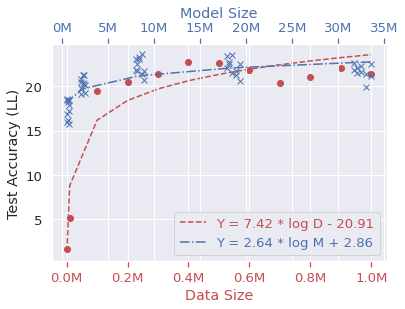

In [72]:


x1, y1, popt1, eq1 = scaling_data
xlabel1 = 'Data Size'
x2, y2, popt2, eq2 = scaling_model
xlabel2 = 'Model Size'
ylabel = "Test Accuracy (LL)"

# values for making ticks in x and y axis
ynumbers = np.linspace(0, 25, 6)
xnumbers1 = np.linspace(-1, 1, 11)
xnumbers2 = np.linspace(0, 300, 7)

# separate the figure object and axes object
# from the plotting object
fig, ax1 = plt.subplots()

# Duplicate the axes with a different x axis
# and the same y axis
ax2 = ax1.twiny() # ax2 and ax1 will have common y axis and different x axis

# plot the curves on axes 1, and 2, and get the axes handles
# curve1, = ax1.plot(x1, y1, label=eq1, color='r')
curve1, = ax1.plot(x1, target_func(x1, *popt1), '--', label=eq1, color='r')
ax1.plot(x1, y1, 'ro')

# curve2, = ax2.plot(x2, y2, label=eq2, color='b')
curve2, = ax2.plot(x2, target_func(x2, *popt2), '-.', label=eq2, color='b')
ax2.plot(x2, y2, 'bx')

# Make a curves list to access the parameters in the curves
curves = [curve1, curve2]

# add legend via axes 1 or axes 2 object.
# one command is usually sufficient
# ax1.legend() # will not display the legend of ax2
# ax2.legend() # will not display the legend of ax1
# ax1.legend(curves, [curve.get_label() for curve in curves])
ax2.legend(curves, [curve.get_label() for curve in curves], loc='lower right', labelcolor='linecolor') # also valid

# x axis labels via the axes
ax1.set_xlabel(xlabel1, color=curve1.get_color())
ax2.set_xlabel(xlabel2, color=curve2.get_color())

# y axis label via the axes
ax1.set_ylabel(ylabel)
# ax2.set_ylabel("Magnitude", color=curve2.get_color()) # does not work
# ax2 has no property control over y axis

# y ticks - make them coloured as well
ax1.tick_params(axis='y')
# ax2.tick_params(axis='y', colors=curve2.get_color()) # does not work
# ax2 has no property control over y axis

# x axis ticks via the axes
ax1.tick_params(axis='x', colors=curve1.get_color())
ax2.tick_params(axis='x', colors=curve2.get_color())

# # set x ticks
# ax1.set_xticks(xnumbers1)
# ax2.set_xticks(xnumbers2)

# # set y ticks
# ax1.set_yticks(ynumbers)
# # ax2.set_yticks(ynumbers) # also works

# Grids via axes 1 # use this if axes 1 is used to
# define the properties of common x axis
# ax1.grid(color=curve1.get_color())

# To make grids using axes 2
# ax1.grid(color=curve2.get_color())
# ax2.grid(color=curve2.get_color())
# ax1.xaxis.grid(False)

fmt1 = lambda x, pos: f'{x/1e6:.1f}M'
fmt2 = lambda x, pos: f'{x/1e6:.0f}M'
ax1.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt1))
ax2.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt2))
plt.savefig('figures/scaling_laws.pdf', dpi=300, bbox_inches='tight')
plt.show()